In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats
import numpy as np
import os

In [76]:
plt.rc('legend', fontsize=9)
#plt.rc('text', usetex=True)

In [81]:
# TODO: Maybe refactor options 2 & 3 and f-I plot into one notebook, and option 1 and all other plots into another notebook

# Load data files and extract spike train for each current step (run one of the three options below)
# Option 1: /separate runs/*.dat (NeuroML2)
dt = 0.001
threshold = -0.025
dat_files = [f for f in os.listdir('separate runs') if os.path.isfile(os.path.join('separate runs', f)) and os.path.splitext(f)[1] == '.dat']
currents = np.array([float(f[:-6]) for f in dat_files])  # pA
spike_trains = []
for f in dat_files:
    t, v, i = np.genfromtxt(os.path.join('separate runs', f)).transpose()
    spike_trains.append(v)

In [68]:
# Option 2: increasing.dat (XPP)
spike_trains = []
dt = 0.1
threshold = -25
t, v = np.genfromtxt('increasing.dat').transpose()[:2]
for start in range(int(3050/dt), int(10051/dt), int(500/dt)):
    spike_trains.append(v[start:start+int(400/dt)])  # trim start and end to prevent any spikes from other current steps
currents = np.array([-1.9, -1.7, -1.2, -0.5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

In [61]:
# Option 3: decreasing.dat (XPP)
spike_trains = []
dt = 0.1
threshold = -25
t, v = np.genfromtxt('decreasing.dat').transpose()[:2]
for start in range(int(50/dt), int(7551/dt), int(500/dt)):
    spike_trains.append(v[start:start+int(400/dt)])  # trim start and end to prevent any spikes from other current steps
currents = np.array([50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 0, -1.2 , -1.9, -2.4, -2.7, -2.72])
#spike_trains

In [82]:
# Helper functions; run these after loading the data files
# TODO: Make these better
ms_to_index = lambda ms: int(ms / dt)
index_to_ms = lambda ind: ind * dt

Ipulse = -1.5 pA


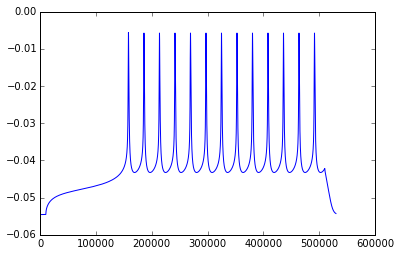

In [83]:
# Plot a single spike train
i = 0
plt.plot(spike_trains[i])
#plt.xlim(157000, 185000)
print 'Ipulse =', currents[i], 'pA'

In [84]:
# Extract spike times via voltage threshold
spike_times = []
for spike_train in spike_trains:
    current_spike_times = []
    for i in range(spike_train.size-1):
        if spike_train[i] < threshold and spike_train[i+1] >= threshold:
            current_spike_times.append(index_to_ms(i))
    spike_times.append(np.array(current_spike_times))
#spike_times

In [72]:
# Durations between spikes and spiking frequencies
durations = [times[1:] - times[:-1] for times in spike_times]  # time between spikes, ms
frequencies = [1000. / d for d in durations]  # Hz
#frequencies

In [73]:
mean_frequencies = map(np.mean, frequencies)
sem_frequencies = map(sp.stats.sem, frequencies)

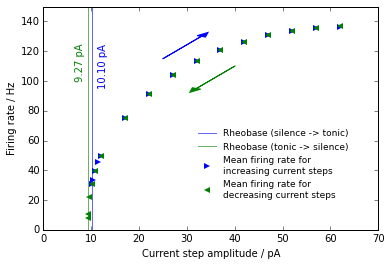

In [80]:
plt.axvline(-1.90+12, label="Rheobase (silence -> tonic)", color='b', alpha=0.6)
plt.text(11.4, 120, '10.10 pA', color='b', rotation=90)
plt.errorbar(currents+12, mean_frequencies, fmt='b>', capsize=7, label="Mean firing rate for\nincreasing current steps", markeredgecolor='none')  # yerr=sem_frequencies
plt.arrow(25, 115, 8, 15, head_width=2, head_length=3, fc='b', ec='b')

# Plot frequencies for decreasing current steps in the same plot as for increasing current steps
# Steps: Run analysis for decreasing.dat (option 3), swap values in cell below, run analysis again for increasing.dat (option 2), finally run this cell to plot
plt.axvline(-2.73+12, label="Rheobase (tonic -> silence)", color='g', alpha=0.6)
plt.text(6.5, 120, '9.27 pA', color='g', rotation=90)
plt.errorbar(currents_2+12, mean_frequencies_2, fmt='g<', capsize=7, label="Mean firing rate for\ndecreasing current steps", markeredgecolor='none')  # yerr=sem_frequencies_2
plt.arrow(40, 110, -8, -15, head_width=2, head_length=3, fc='g', ec='g')

plt.ylim(0, 150)
plt.xlim(0, 70)
plt.xlabel('Current step amplitude / pA')
plt.ylabel('Firing rate / Hz')
plt.legend(loc='lower right', numpoints=1, borderaxespad=3, frameon=False)

fit = np.poly1d(np.polyfit(currents+12, mean_frequencies, 3))
x = np.linspace(1, 70)
#plt.plot(x, fit(x), 'black', linewidth=0.3)

plt.savefig("f-I-curve.png", dpi=300)

In [67]:
# Swap values to plot frequencies for both in- and decreasing current steps (see above)
mean_frequencies_2 = mean_frequencies
sem_frequencies_2 = sem_frequencies
currents_2 = currents

In [ ]:
# Variation of frequencies
for sem, mean in zip(sem_frequencies_2, mean_frequencies_2):
    print sem / mean

In [85]:
# Delays to first spike
delays = [times[0] - 10 if len(t) > 0 else np.nan for times in spike_times]  # current pulse starts at 10 ms
delays

[147.34800000000001,
 326.71699999999998,
 88.677999999999997,
 53.649000000000001,
 13.212,
 9.8360000000000021,
 7.8680000000000021,
 6.5689999999999991,
 5.6419999999999995,
 4.9459999999999997,
 4.402000000000001,
 3.9649999999999999,
 3.604000000000001,
 20.553000000000001]

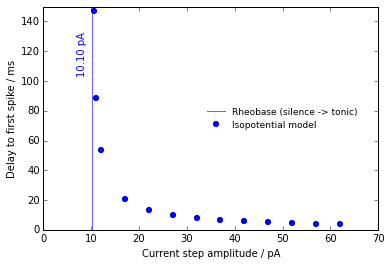

In [86]:
plt.errorbar(currents+12, delays, fmt='o', capsize=7, markeredgecolor='none', label='Isopotential model')  #yerr=0.001,
plt.xlim(0, 70)
plt.ylim(0, 150)
plt.xlabel('Current step amplitude / pA')
plt.ylabel('Delay to first spike / ms')
plt.axvline(-1.90+12, label="Rheobase (silence -> tonic)", color='b', alpha=0.6)
plt.text(7, 128, '10.10 pA', color='b', rotation=90)
plt.legend(loc='center right', numpoints=1, borderaxespad=2, frameon=False)
plt.savefig("delay.png", dpi=300)

In [104]:
# Minima, maxima and amplitudes (maxima - minima) of membrane voltage during spikes
minima = []
maxima = []
amplitudes = []
for spike_train, times in zip(spike_trains, spike_times):
    current_minima = []
    current_maxima = []
    current_amplitudes = []
    for i in range(len(times)-1):
        start = ms_to_index(times[i])
        end = ms_to_index(times[i+1])
        minimum = np.min(spike_train[start:end] * 1000)  # mV
        maximum = np.max(spike_train[start:end] * 1000)  # mV
        current_minima.append(maximum)
        current_maxima.append(minimum)
        current_amplitudes.append(maximum - minimum)
    minima.append(np.array(current_minima))
    maxima.append(np.array(current_maxima))
    amplitudes.append(np.array(current_amplitudes))
zip(minima, maxima, amplitudes)

[(array([-5.6504416, -5.7724956, -5.7722586, -5.772307 , -5.7723   ,
         -5.7722908, -5.772285 , -5.772281 , -5.772279 , -5.772268 ,
         -5.7722726, -5.772264 ]),
  array([-43.25513 , -43.254238, -43.253053, -43.252464, -43.252043,
         -43.251716, -43.251455, -43.251254, -43.251093, -43.250967,
         -43.25087 , -43.25079 ]),
  array([ 37.6046884,  37.4817424,  37.4807944,  37.480157 ,  37.479743 ,
          37.4794252,  37.47917  ,  37.478973 ,  37.478814 ,  37.478699 ,
          37.4785974,  37.478526 ])),
 (array([-5.792357 , -5.8489535, -5.848868 , -5.848834 , -5.8487873]),
  array([-43.476403, -43.47448 , -43.473545, -43.473043, -43.472677]),
  array([ 37.684046 ,  37.6255265,  37.624677 ,  37.624209 ,  37.6238897])),
 (array([-5.4171993, -5.7013333, -5.7002488, -5.7005235, -5.700599 ,
         -5.700646 , -5.7006814, -5.700714 , -5.7007386, -5.7007507,
         -5.7007717, -5.7007778, -5.700788 , -5.7008048, -5.700802 ,
         -5.7008076, -5.7008127]),
  array

In [107]:
mean_minima = map(np.mean, [x[2:-1] for x in minima])  # exclude first two spikes and last spike to eliminate effects at the start and end of the current step
sem_minima = map(sp.stats.sem, [x[2:-1] for x in minima])
mean_maxima = map(np.mean, [x[2:-1] for x in maxima])
sem_maxima = map(sp.stats.sem, [x[2:-1] for x in maxima])
mean_amplitudes = map(np.mean, [x[2:-1] for x in amplitudes])
sem_amplitudes = map(sp.stats.sem, [x[2:-1] for x in amplitudes])

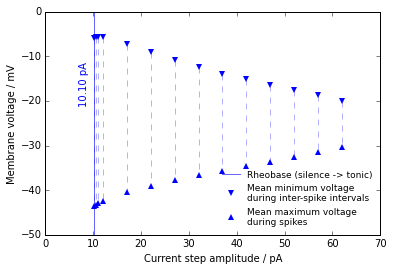

In [109]:
plt.errorbar(currents+12, mean_minima, fmt='v', color='b', capsize=7, markeredgecolor='none', label='Mean minimum voltage\nduring inter-spike intervals')  # yerr=sem_minima
plt.errorbar(currents+12, mean_maxima, fmt='^', color='b', capsize=7, markeredgecolor='none', label='Mean maximum voltage\nduring spikes')  # yerr=sem_maxima

plt.vlines(currents+12, mean_minima, mean_maxima, alpha=0.3, color='b', linestyle='--')

plt.xlabel('Current step amplitude / pA')
plt.ylabel('Membrane voltage / mV')
plt.xlim(0, 70)
plt.ylim(-50, 0)
plt.axvline(-1.90+12, label="Rheobase (silence -> tonic)", color='b', alpha=0.6)
plt.text(7, -13, '10.10 pA', color='b', rotation=90)
plt.legend(loc='lower right', numpoints=1, borderaxespad=0.5, frameon=False)
plt.savefig("min_max.png", dpi=300)

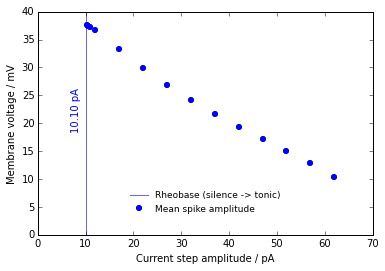

In [139]:
plt.errorbar(currents+12, mean_amplitudes, fmt='o', capsize=7, markeredgecolor='none', label='Mean spike amplitude')  # yerr=sem_amplitudes
plt.xlabel('Current step amplitude / pA')
plt.ylabel('Membrane voltage / mV')
plt.xlim(0, 70)
plt.ylim(0, 40)
plt.axvline(-1.90+12, label="Rheobase (silence -> tonic)", color='b', alpha=0.6)
plt.text(7, 25, '10.10 pA', color='b', rotation=90)
plt.legend(loc='lower center', numpoints=1, borderaxespad=2, frameon=False)

fit = np.poly1d(np.polyfit(currents+12, np.array(mean_amplitudes), 1))
x = np.linspace(1, 70)
#plt.plot(x, fit(x), 'black', linewidth=0.3)

plt.savefig("amplitudes.png", dpi=300)